In [1]:
%load_ext nb_black
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("svg")

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

import jax.numpy as jnp
import jax
from jax import vmap
from jax.scipy.special import xlogy

jax.config.update("jax_enable_x64", True)
import scipy.linalg

from collections import defaultdict
import gzip

from Bio import AlignIO, SeqIO
from Bio.Align import MultipleSeqAlignment
from ete3 import Tree
from datetime import datetime, MINYEAR

from vbsky.fasta import SeqData
from vbsky.bdsky import _lognorm_logpdf
from vbsky.prob import VF
from vbsky.prob.distribution import PointMass
from vbsky.prob.transform import (
    Transform,
    Compose,
    Affine,
    Blockwise,
    Positive,
    ZeroOne,
    DiagonalAffine,
    Householder,
    Shift,
    Scale,
    Bounded,
    Exp,
    Softplus,
    Concat,
)
from vbsky.prob.distribution import Constant
from vbsky.prob import arf

from vbsky.plot import *

pos = Compose(DiagonalAffine, Exp)
plus = Compose(DiagonalAffine, Positive)
z1 = Compose(DiagonalAffine, ZeroOne)

/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_1958/944552378.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


<IPython.core.display.Javascript object>

## Data Preprocessing After Download from Gisaid

In [2]:
# Filter from original alignment

# def filter_alignment(filter_by, name):
#     sids = []
#     seqs = []
#     fn = "covid/msa_1222.fasta"
#     with open(fn, "rt") as file:
#         with open(f"covid/{name}.fa", "w") as file2:
#             it = enumerate(file)
#             for i, line in it:
#                 if i % 2 == 0:
#                     if filter_by in line:
#                         desc = line.split("|")
#                         date = desc[2]
#                         if date[-5:-3] == "00":
#                             continue
#                         file2.write(line)
#                         file2.write(next(it)[1])

# filter_alignment("USA/MI", "mi")
# filter_alignment("USA/FL", "fl")
# filter_alignment("USA", "usa")

<IPython.core.display.Javascript object>

In [3]:
# Set up audacity tree


# def filter_audacity_tree(subset, name):
#     global_tree = Tree("covid/global.tree", format=1)
#     leaves = set([leaf.name for leaf in global_tree])

#     seqs = []
#     to_prune = []

#     for s in subset:
#         desc = s.description.split("|")
#         if desc[1] in leaves:
#             seqs.append(s)
#             to_prune.append(desc[1])

#     global_tree.prune(to_prune, preserve_branch_length=True)
#     global_tree.write(outfile=f"covid/global_{name}.tree")
#     SeqIO.write(MultipleSeqAlignment(seqs), f"covid/audacity_{name}.fa", "fasta")


# florida = AlignIO.read("covid/fl.fa", format="fasta")
# filter_audacity_tree(florida, "fl")

# michigan = AlignIO.read("covid/mi.fa", format="fasta")
# filter_audacity_tree(michigan, "mi")

<IPython.core.display.Javascript object>

In [4]:
# usa = AlignIO.read("covid/usa.fa", format="fasta")
# filter_audacity_tree(usa, "usa")

<IPython.core.display.Javascript object>

## Helper Functions

In [5]:
def _params_prior_loglik(params):
    ll = 0
    tau = {"R": params["precision_R"][0], "s": params["precision_s"][0]}
    ll += jax.scipy.stats.gamma.logpdf(tau["R"], a=0.001, scale=1 / 0.001)
    ll += jax.scipy.stats.gamma.logpdf(tau["s"], a=0.001, scale=1 / 0.001)

    ll += jax.scipy.stats.beta.logpdf(params["s"], 0.02, 0.98).sum()

    #     mus = [0.5, 4.1, -2]
    #     sigmas = [1, 0.5, 0.5]

    mus = [1.0, -1.2]
    sigmas = [1, 0.1]

    for i, k in enumerate(["R", "origin"]):
        #     for i, k in enumerate(["R"]):
        log_rate = jnp.log(params[k])
        ll += _lognorm_logpdf(log_rate, mu=mus[i], sigma=sigmas[i]).sum()

    for k in ["R", "s"]:
        log_rate = jnp.log(params[k])
        if k in ["R", "delta", "s"]:
            ll -= (tau[k] / 2) * (jnp.diff(log_rate) ** 2).sum()
            m = len(log_rate)
            ll += xlogy((m - 1) / 2, tau[k] / (2 * jnp.pi))
    return ll


def _params_prior_loglik_less_smooth(params):
    ll = 0
    tau = {"R": params["precision_R"][0], "s": params["precision_s"][0]}
    ll += jax.scipy.stats.gamma.logpdf(tau["R"], a=10, scale=0.1 / 10)
    ll += jax.scipy.stats.gamma.logpdf(tau["s"], a=10, scale=0.1 / 10)

    ll += jax.scipy.stats.beta.logpdf(params["s"], 20, 980).sum()

    #     mus = [0.5, 4.1, -2]
    #     sigmas = [1, 0.5, 0.5]

    mus = [1.0, -1.2]
    sigmas = [1, 0.1]

    for i, k in enumerate(["R", "origin"]):
        #     for i, k in enumerate(["R"]):
        log_rate = jnp.log(params[k])
        ll += _lognorm_logpdf(log_rate, mu=mus[i], sigma=sigmas[i]).sum()

    for k in ["R", "s"]:
        log_rate = jnp.log(params[k])
        if k in ["R", "delta", "s"]:
            ll -= (tau[k] / 2) * (jnp.diff(log_rate) ** 2).sum()
            m = len(log_rate)
            ll += xlogy((m - 1) / 2, tau[k] / (2 * jnp.pi))
    return ll


def _params_prior_loglik_bias(params):
    ll = 0
    tau = {"R": params["precision_R"][0], "s": params["precision_s"][0]}
    ll += jax.scipy.stats.gamma.logpdf(tau["R"], a=0.001, scale=1 / 0.001)
    ll += jax.scipy.stats.gamma.logpdf(tau["s"], a=0.001, scale=1 / 0.001)

    ll += jax.scipy.stats.beta.logpdf(params["s"], 20, 980).sum()

    #     mus = [0.5, 4.1, -2]
    #     sigmas = [1, 0.5, 0.5]

    mus = [1.0, -1.2]
    sigmas = [1, 0.1]

    #     for i, k in enumerate(["R", "origin"]):
    for i, k in enumerate(["R"]):
        log_rate = jnp.log(params[k])
        ll += _lognorm_logpdf(log_rate, mu=mus[i], sigma=sigmas[i]).sum()

    for k in ["R", "s"]:
        log_rate = jnp.log(params[k])
        if k in ["R", "delta", "s"]:
            ll -= (tau[k] / 2) * (jnp.diff(log_rate) ** 2).sum()
            m = len(log_rate)
            ll += xlogy((m - 1) / 2, tau[k] / (2 * jnp.pi))
    return ll


priors = {
    "original": _params_prior_loglik,
    "less": _params_prior_loglik_less_smooth,
    "bias": _params_prior_loglik_bias,
}


def default_flows(data, m, rate):

    local_flows = [
        {"proportions": Transform(td.n - 2, z1), "root_proportion": Transform(1, z1)}
        for td in data.tds
    ]

    global_flows = VF(
        origin=Transform(1, pos),
        #         origin=Constant(0.3),
        origin_start=Constant(data.earliest),
        # delta=Transform(m, pos),
        delta=Constant(np.repeat(36.5, m)),
        R=Transform(m, pos),
        rho_m=Constant(0),
        s=Transform(m, z1),
        #         s=Constant(np.repeat(0.02, m)),
        # precision=Constant(1.0),
        precision_R=Transform(1, pos),
        precision_s=Transform(1, pos),
        clock_rate=Constant(rate),
    )
    return global_flows, local_flows


def fixed_origin_flows(data, m, rate):

    local_flows = [
        {"proportions": Transform(td.n - 2, z1), "root_proportion": Transform(1, z1)}
        for td in data.tds
    ]

    global_flows = VF(
        origin=Constant(0.3),
        origin_start=Constant(data.earliest),
        delta=Constant(np.repeat(36.5, m)),
        R=Transform(m, pos),
        rho_m=Constant(0),
        s=Transform(m, z1),
        precision_R=Transform(1, pos),
        precision_s=Transform(1, pos),
        clock_rate=Constant(rate),
    )
    return global_flows, local_flows


rate = 1.12e-3

<IPython.core.display.Javascript object>

In [6]:
external_df = pd.read_csv("covid/external.csv")
external = {}

for k in ["florida", "michigan"]:
    external[k] = external_df.loc[
        (external_df["stateName"].str.lower() == k) & (~(external_df["rt"].isna()))
    ]

    external[k]["date"] = pd.to_datetime(external[k]["date"])
    external[k]["time"] = (
        external[k]["date"].dt.year + (external[k]["date"].dt.dayofyear - 1) / 365.245
    )


def plot_external(ax, region):
    color = next(ax._get_lines.prop_cycler)["color"]
    ax.plot(
        external[region]["time"],
        external[region]["rt"],
        label="Surveillance Data",
        color=color,
    )
    ax.fill_between(
        external[region]["time"],
        external[region]["rt_lower"],
        external[region]["rt_upper"],
        alpha=0.1,
        label="_nolegend_",
        color=color,
    )

/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_1958/194997826.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  external[k]["date"] = pd.to_datetime(external[k]["date"])
/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_1958/194997826.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  external[k]["time"] = (


<IPython.core.display.Javascript object>

## Run Analysis

In [7]:
fasta = {}
fasta["florida"] = AlignIO.read("covid/audacity_fl.fa", format="fasta")
fasta["michigan"] = AlignIO.read("covid/audacity_mi.fa", format="fasta")
fasta["usa"] = AlignIO.read("covid/audacity_usa.fa", format="fasta")

<IPython.core.display.Javascript object>

In [8]:
# data = {k: SeqData(v, right_end=datetime(2021, 11, 15)) for k, v in fasta.items()}
data = {k: SeqData(v) for k, v in fasta.items()}

<IPython.core.display.Javascript object>

In [ ]:
sns.kdeplot(data["florida"].dates, alpha=0.7, label="Florida")
sns.kdeplot(data["michigan"].dates, alpha=0.7, label="Michigan")
sns.kdeplot(data["usa"].dates, alpha=0.7, label="USA")
plt.xticks(rotation=30)
_ = plt.legend(loc="upper left")
plt.savefig("covid/figures/all/sample_times.pdf", format="pdf")

In [9]:
%%time 
n_tips = 200
temp_folder = "covid/temp"
tree_path = "covid/temp/subsample.trees"
audacity = True
stratified = False
stratify_by = None

for k, v in data.items():
    if "florida" in k:
        audacity_tree_path = "covid/global_fl.tree"
    elif "michigan" in k:
        audacity_tree_path = "covid/global_mi.tree"
    else: 
        audacity_tree_path = "covid/global_usa.tree"
        
    if stratified:
        stratify_by = defaultdict(list)
        for s, d in zip(v.sids, v.dates):
            days = (v.max_date - d).days
            stratify_by[(d.year, (d.month-1)//3)].append(s)
            
    n_trees = min(int(np.ceil(v.n / n_tips)), 50)
#     n_trees = 50
    v.prep_data(
        n_tips,
        n_trees,
        temp_folder,
        tree_path,
        audacity=audacity,
        audacity_tree_path=audacity_tree_path,
        stratified=stratified,
        stratify_by=stratify_by
    )

Readying trees


100%|███████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.07it/s]


Processing audacity trees


100%|███████████████████████████████████████████████████| 50/50 [00:25<00:00,  2.00it/s]


Writing audacity pruned trees
Processing trees


100%|███████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.31it/s]


Readying tip data


100%|███████████████████████████████████████████████████| 50/50 [03:21<00:00,  4.04s/it]


Readying trees


100%|███████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.71it/s]


Processing audacity trees


100%|███████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.53it/s]

Writing audacity pruned trees
Processing trees



100%|███████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.56it/s]


Readying tip data


100%|███████████████████████████████████████████████████| 50/50 [02:30<00:00,  3.02s/it]


Readying trees


100%|███████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.33s/it]


Processing audacity trees


100%|███████████████████████████████████████████████████| 50/50 [07:38<00:00,  9.16s/it]

Writing audacity pruned trees
Processing trees



100%|███████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.59it/s]


Readying tip data


100%|███████████████████████████████████████████████████| 50/50 [03:20<00:00,  4.02s/it]


CPU times: user 1min 58s, sys: 1min 28s, total: 3min 26s
Wall time: 20min 20s


<IPython.core.display.Javascript object>

## Uninformative smoothness

In [10]:
m = 50

for k, v in data.items():
    global_flows, local_flows = default_flows(v, m, rate)
    v.setup_flows(global_flows, local_flows)

rng = jax.random.PRNGKey(6)
res = {}
n_iter = 10
threshold = 0.001
step_size = 1.0
for k, v in data.items():
    res[k] = v.loop(
        priors["original"], rng, n_iter, step_size=step_size, threshold=threshold
    )

 66%|████████████████████████████████▎                | 330/500 [06:44<03:28,  1.23s/it]


<IPython.core.display.Javascript object>

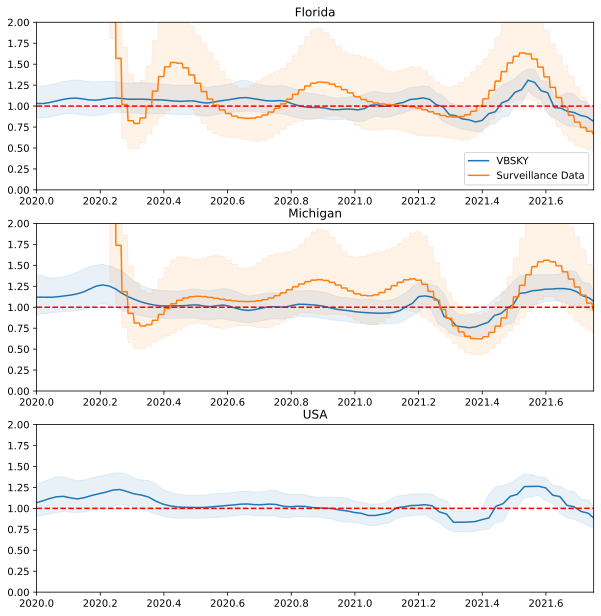

<IPython.core.display.Javascript object>

In [11]:
regions = ["florida", "michigan", "usa"]
fig, axs = plt.subplots(len(regions))
plot_by_param(res, data, axs, m, regions, "R")
for i, r in enumerate(regions[:-1]):
    plot_external(axs[i], r)
fig.set_size_inches(10, 3.5 * len(regions))

for ax in axs:
    ax.set_ylim(0, 2)
    ax.set_xlim(2020, 2021.75)
    ax.axhline(y=1, linestyle="--", color="r")

axs[0].legend(loc="lower right")
# fig.savefig("covid/figures/all/smooth_R.pdf", format="pdf")

/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


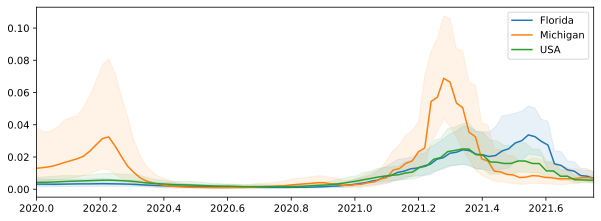

<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 3.5)

for r in regions:
    start, top, end, x0 = plot_helper(res[r], data[r], 200)
    if r == "usa":
        title = r.upper()
    else:
        title = r.title()
    plot_one(res[r], ax, "s", m, start, top, end, x0, title, "fill", "")
ax.set_xlim(2020, 2021.75)

plt.legend()
fig.savefig("covid/figures/all/smooth_s.pdf", format="pdf")

## Less Smoothing

In [17]:
m = 50

for k, v in data.items():
    global_flows, local_flows = default_flows(v, m, rate)
    v.setup_flows(global_flows, local_flows)

rng = jax.random.PRNGKey(6)
res_less = {}
n_iter = 10
threshold = 0.001
step_size = 1.0
for k, v in data.items():
    res_less[k] = v.loop(
        priors["less"], rng, n_iter, step_size=step_size, threshold=threshold
    )

 66%|████████████████████████████████▎                | 330/500 [06:23<03:17,  1.16s/it]


<IPython.core.display.Javascript object>

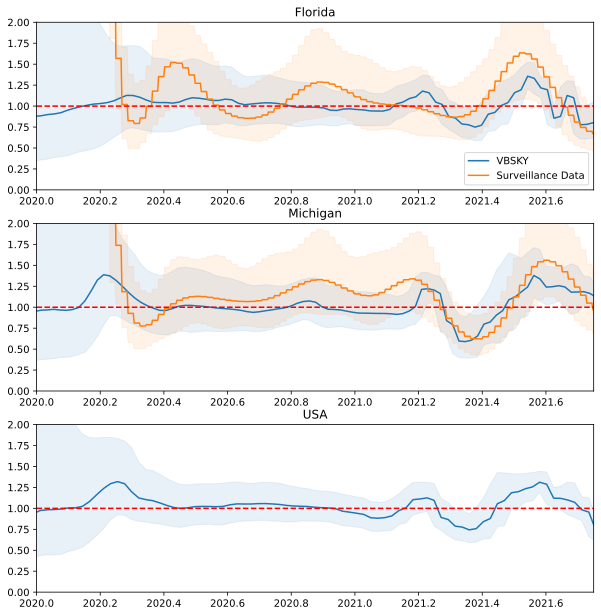

<IPython.core.display.Javascript object>

In [18]:
regions = ["florida", "michigan", "usa"]
fig, axs = plt.subplots(len(regions))
plot_by_param(res_less, data, axs, m, regions, "R")
for i, r in enumerate(regions[:-1]):
    plot_external(axs[i], r)
fig.set_size_inches(10, 3.5 * len(regions))

for ax in axs:
    ax.set_ylim(0, 2)
    ax.set_xlim(2020, 2021.75)
    ax.axhline(y=1, linestyle="--", color="r")

axs[0].legend(loc="lower right")
# fig.savefig("covid/figures/all/less_smooth_strong_prior_R.pdf", format="pdf")

/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


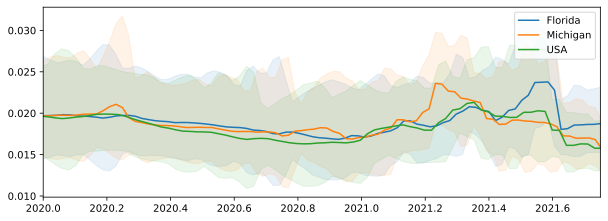

<IPython.core.display.Javascript object>

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 3.5)

for r in regions:
    start, top, end, x0 = plot_helper(res_less[r], data[r], 200)
    if r == "usa":
        title = r.upper()
    else:
        title = r.title()
    plot_one(res_less[r], ax, "s", m, start, top, end, x0, title, "fill", "")

ax.set_xlim(2020, 2021.75)

plt.legend()
fig.savefig("covid/figures/all/less_smooth_strong_prior_s.pdf", format="pdf")

## Biased Sampling

In [8]:
data2 = {k: SeqData(v) for k, v in fasta.items()}

<IPython.core.display.Javascript object>

In [9]:
n_tips = 200
temp_folder = "covid/temp"
tree_path = "covid/temp/subsample.trees"
audacity = True
stratified = True
stratify_by = None

for k, v in data2.items():
    if "florida" in k:
        audacity_tree_path = "covid/global_fl.tree"
    elif "michigan" in k:
        audacity_tree_path = "covid/global_mi.tree"
    else:
        audacity_tree_path = "covid/global_usa.tree"

    if stratified:
        stratify_by = defaultdict(list)
        for s, d in zip(v.sids, v.dates):
            days = (v.max_date - d).days
            stratify_by[(d.year, (d.month - 1) // 3)].append(s)

    n_trees = min(int(np.ceil(v.n / n_tips)), 50)
    v.prep_data(
        n_tips,
        n_trees,
        temp_folder,
        tree_path,
        audacity=audacity,
        audacity_tree_path=audacity_tree_path,
        stratified=stratified,
        stratify_by=stratify_by,
    )

Readying trees


100%|███████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.77it/s]


Processing audacity trees


100%|███████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.35it/s]


Writing audacity pruned trees
Processing trees


100%|███████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.37it/s]


Readying tip data


100%|███████████████████████████████████████████████████| 50/50 [02:51<00:00,  3.44s/it]


Readying trees


100%|███████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


Processing audacity trees


100%|███████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.69it/s]

Writing audacity pruned trees
Processing trees



100%|███████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.56it/s]


Readying tip data


100%|███████████████████████████████████████████████████| 50/50 [02:48<00:00,  3.36s/it]


Readying trees


100%|███████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s]


Processing audacity trees


100%|███████████████████████████████████████████████████| 50/50 [07:13<00:00,  8.66s/it]

Writing audacity pruned trees
Processing trees



100%|███████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.53it/s]


Readying tip data


100%|███████████████████████████████████████████████████| 50/50 [03:36<00:00,  4.34s/it]


<IPython.core.display.Javascript object>

In [10]:
m = 50

for k, v in data2.items():
    global_flows, local_flows = fixed_origin_flows(v, m, rate)
    v.setup_flows(global_flows, local_flows)

rng = jax.random.PRNGKey(6)
res_bias = {}
n_iter = 10
threshold = 0.001
step_size = 1.0
for k, v in data2.items():
    res_bias[k] = v.loop(
        priors["bias"], rng, n_iter, step_size=step_size, threshold=threshold
    )

 86%|██████████████████████████████████████████▎      | 432/500 [08:04<01:16,  1.12s/it]


<IPython.core.display.Javascript object>

/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


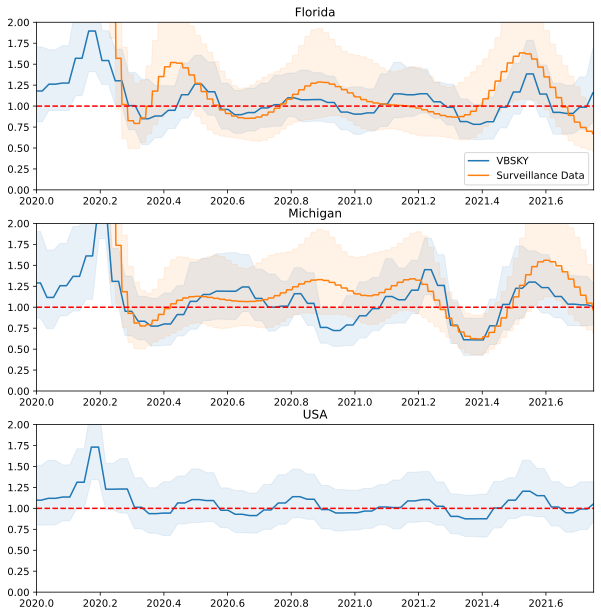

<IPython.core.display.Javascript object>

In [11]:
regions = ["florida", "michigan", "usa"]
fig, axs = plt.subplots(len(regions))
plot_by_param(res_bias, data2, axs, m, regions, "R")
for i, r in enumerate(regions[:-1]):
    plot_external(axs[i], r)
fig.set_size_inches(10, 3.5 * len(regions))

for ax in axs:
    ax.set_ylim(0, 2)
    ax.set_xlim(2020, 2021.75)
    ax.axhline(y=1, linestyle="--", color="r")

axs[0].legend(loc="lower right")
fig.savefig("covid/figures/all/bias_R_strong_prior_s.pdf", format="pdf")

/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


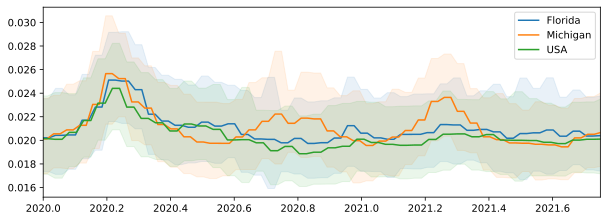

<IPython.core.display.Javascript object>

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 3.5)


for r in regions:
    start, top, end, x0 = plot_helper(res_bias[r], data2[r], 200)
    if r == "usa":
        title = r.upper()
    else:
        title = r.title()
    plot_one(res_bias[r], ax, "s", m, start, top, end, x0, title, "fill", "")
ax.set_xlim(2020, 2021.75)

plt.legend()
fig.savefig("covid/figures/all/bias_s_strong_prior_s.pdf", format="pdf")

## Parameter Tuning (ntrees and ntips)

In [6]:
fasta = {}
fasta["florida"] = AlignIO.read("covid/audacity_fl.fa", format="fasta")
fasta["usa"] = AlignIO.read("covid/audacity_usa.fa", format="fasta")

<IPython.core.display.Javascript object>

In [7]:
data = {k: SeqData(v) for k, v in fasta.items()}

<IPython.core.display.Javascript object>

In [8]:
nts = [10, 25, 50, 100, 150]
# nts = [10, 25]
regions = ["florida", "usa"]
data_trees = {f"{b}_{n}": SeqData(fasta["florida"]) for n in nts for b in regions}

n_tips = 200
temp_folder = "covid/temp"
tree_path = "covid/temp/subsample.trees"
audacity = True
audacity_tree_path = "covid/global_fl.tree"
stratified = False

for b in regions:
    for n in nts:
        n_trees = n
        data_trees[f"{b}_{n}"].prep_data(
            n_tips,
            n_trees,
            temp_folder,
            tree_path,
            audacity=audacity,
            audacity_tree_path=audacity_tree_path,
            stratified=stratified,
        )

Readying trees


100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.99it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.56it/s]


Readying tip data


100%|█████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.90s/it]


Readying trees


100%|█████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.19it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.05it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.71it/s]


Readying tip data


100%|█████████████████████████████████████████████████████| 25/25 [01:21<00:00,  3.26s/it]


Readying trees


100%|█████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.93it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


Writing audacity pruned trees
Processing trees


100%|█████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.58it/s]


Readying tip data


100%|█████████████████████████████████████████████████████| 50/50 [02:39<00:00,  3.18s/it]


Readying trees


100%|███████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


Processing audacity trees


100%|███████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.93it/s]

Writing audacity pruned trees
Processing trees



100%|███████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.85it/s]


Readying tip data


100%|███████████████████████████████████████████████████| 100/100 [04:58<00:00,  2.99s/it]


Readying trees


100%|███████████████████████████████████████████████████| 150/150 [00:34<00:00,  4.30it/s]


Processing audacity trees


100%|███████████████████████████████████████████████████| 150/150 [00:52<00:00,  2.86it/s]


Writing audacity pruned trees
Processing trees


100%|███████████████████████████████████████████████████| 150/150 [00:03<00:00, 46.14it/s]


Readying tip data


100%|███████████████████████████████████████████████████| 150/150 [07:28<00:00,  2.99s/it]


Readying trees


100%|█████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.79it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.55it/s]


Readying tip data


100%|█████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.77s/it]


Readying trees


100%|█████████████████████████████████████████████████████| 25/25 [00:12<00:00,  1.99it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.25it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.79it/s]


Readying tip data


100%|█████████████████████████████████████████████████████| 25/25 [01:26<00:00,  3.44s/it]


Readying trees


100%|█████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.47it/s]


Readying tip data


100%|█████████████████████████████████████████████████████| 50/50 [02:33<00:00,  3.08s/it]


Readying trees


100%|███████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]


Processing audacity trees


100%|███████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.93it/s]


Writing audacity pruned trees
Processing trees


100%|███████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.35it/s]


Readying tip data


100%|███████████████████████████████████████████████████| 100/100 [04:57<00:00,  2.98s/it]


Readying trees


100%|███████████████████████████████████████████████████| 150/150 [00:35<00:00,  4.26it/s]


Processing audacity trees


100%|███████████████████████████████████████████████████| 150/150 [00:51<00:00,  2.89it/s]


Writing audacity pruned trees
Processing trees


100%|███████████████████████████████████████████████████| 150/150 [00:03<00:00, 47.70it/s]


Readying tip data


100%|███████████████████████████████████████████████████| 150/150 [07:17<00:00,  2.92s/it]


<IPython.core.display.Javascript object>

In [9]:
m = 50

for k, v in data_trees.items():
    global_flows, local_flows = default_flows(v, m, rate)
    v.setup_flows(global_flows, local_flows)

rng = jax.random.PRNGKey(6)
res_trees = {}
n_iter = 10
threshold = 0.001
step_size = 1.0
for k, v in data_trees.items():
    res_trees[k] = v.loop(
        priors["original"], rng, n_iter, step_size=step_size, threshold=threshold
    )

 64%|███████████████████████████████▉                  | 958/1500 [15:32<08:47,  1.03it/s]


<IPython.core.display.Javascript object>

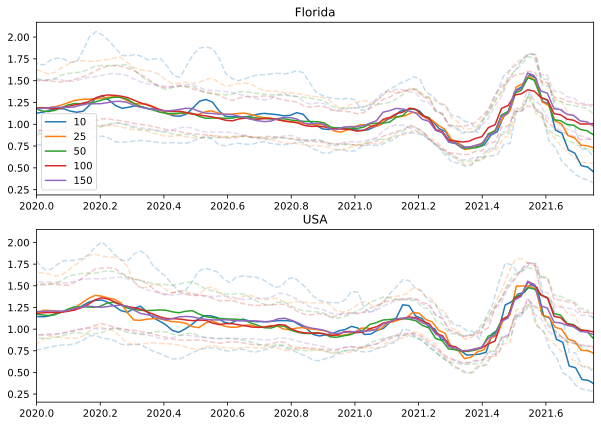

<IPython.core.display.Javascript object>

In [10]:
fig, axs = plt.subplots(2)
fig.set_size_inches(10, 7)

for i, b in enumerate(regions):
    for n in nts:
        start, top, end, x0 = plot_helper(
            res_trees[f"{b}_{n}"], data_trees[f"{b}_{n}"], 200
        )
        if b == "usa":
            title = b.upper()
        else:
            title = b.title()
        plot_one(
            res_trees[f"{b}_{n}"],
            axs[i],
            "R",
            m,
            start,
            top,
            end,
            x0,
            n,
            "lines",
            title,
        )

axs[0].set_xlim(2020, 2021.75)
axs[1].set_xlim(2020, 2021.75)
axs[0].legend(loc="lower left")

fig.savefig("covid/figures/all/n_trees_R.pdf", format="pdf")

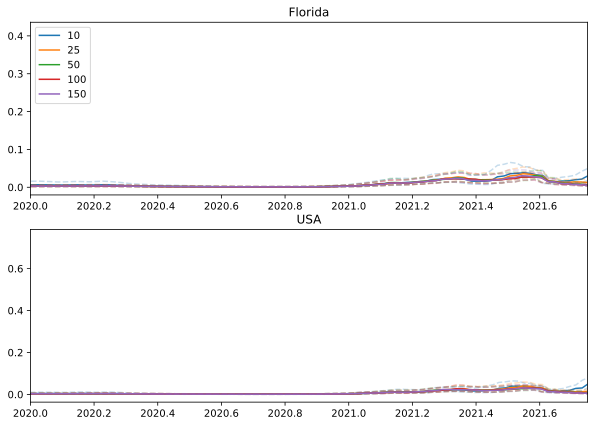

<IPython.core.display.Javascript object>

In [11]:
fig, axs = plt.subplots(2)
fig.set_size_inches(10, 7)

for i, b in enumerate(regions):
    for n in nts:
        start, top, end, x0 = plot_helper(
            res_trees[f"{b}_{n}"], data_trees[f"{b}_{n}"], 200
        )
        if b == "usa":
            title = b.upper()
        else:
            title = b.title()
        plot_one(
            res_trees[f"{b}_{n}"],
            axs[i],
            "s",
            m,
            start,
            top,
            end,
            x0,
            n,
            "lines",
            title,
        )

axs[0].set_xlim(2020, 2021.75)
axs[1].set_xlim(2020, 2021.75)
axs[0].legend(loc="upper left")

fig.savefig("covid/figures/all/n_trees_s.pdf", format="pdf")

In [8]:
n_tipss = [50, 100, 200, 400]
# n_tipss = [50, 100]
regions = ["florida", "usa"]
data_tips = {f"{b}_{n}": SeqData(fasta["florida"]) for n in n_tipss for b in regions}

n_trees = 50
temp_folder = "covid/temp"
tree_path = "covid/temp/subsample.trees"
audacity = True
audacity_tree_path = "covid/global_fl.tree"
stratified = False

for b in regions:
    for n in n_tipss:
        n_tips = n
        data_tips[f"{b}_{n}"].prep_data(
            n_tips,
            n_trees,
            temp_folder,
            tree_path,
            audacity=audacity,
            audacity_tree_path=audacity_tree_path,
            stratified=stratified,
        )

Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.06it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.09it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.71it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.35it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.45it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:21<00:00,  1.63s/it]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.58it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.92it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.41it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.26s/it]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.93it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.55it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.14it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:42<00:00,  6.86s/it]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.76it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.35it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.24it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.28it/s]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.39it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.58it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.63it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.60s/it]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.44it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.29it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.37it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:40<00:00,  3.21s/it]


Readying trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.79it/s]


Processing audacity trees


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.57it/s]

Writing audacity pruned trees
Processing trees



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.92it/s]


Readying tip data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:37<00:00,  6.75s/it]


<IPython.core.display.Javascript object>

In [9]:
m = 50

for k, v in data_tips.items():
    global_flows, local_flows = default_flows(v, m, rate)
    v.setup_flows(global_flows, local_flows)

rng = jax.random.PRNGKey(6)
res_tips = {}
n_iter = 10
threshold = 0.001
step_size = 1.0
for k, v in data_tips.items():
    res_tips[k] = v.loop(
        _params_prior_loglik, rng, n_iter, step_size=step_size, threshold=threshold
    )

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 358/500 [21:24<08:29,  3.59s/it]


<IPython.core.display.Javascript object>

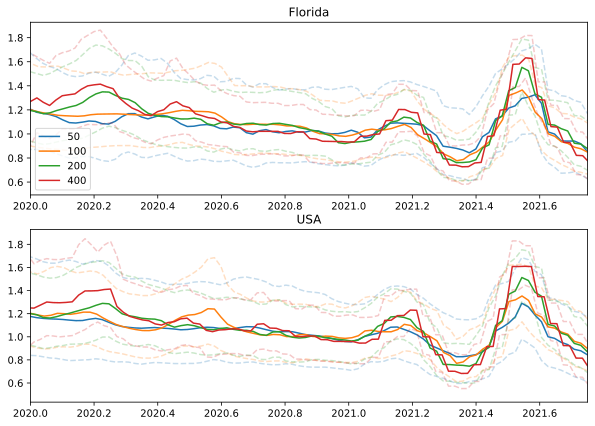

<IPython.core.display.Javascript object>

In [10]:
fig, axs = plt.subplots(2)
fig.set_size_inches(10, 7)

for i, b in enumerate(regions):
    for n in n_tipss:
        start, top, end, x0 = plot_helper(
            res_tips[f"{b}_{n}"], data_tips[f"{b}_{n}"], n
        )
        if b == "usa":
            title = b.upper()
        else:
            title = b.title()
        plot_one(
            res_tips[f"{b}_{n}"], axs[i], "R", m, start, top, end, x0, n, "lines", title
        )

axs[0].set_xlim(2020, 2021.75)
axs[1].set_xlim(2020, 2021.75)
axs[0].legend(loc="lower left")

fig.savefig("covid/figures/all/n_tips_R.pdf", format="pdf")

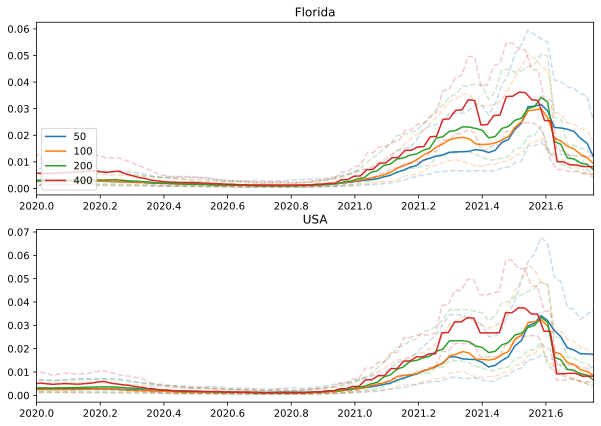

<IPython.core.display.Javascript object>

In [11]:
fig, axs = plt.subplots(2)
fig.set_size_inches(10, 7)

for i, b in enumerate(regions):
    for n in n_tipss:
        start, top, end, x0 = plot_helper(
            res_tips[f"{b}_{n}"], data_tips[f"{b}_{n}"], n
        )
        if b == "usa":
            title = b.upper()
        else:
            title = b.title()
        plot_one(
            res_tips[f"{b}_{n}"], axs[i], "s", m, start, top, end, x0, n, "lines", title
        )

axs[0].set_xlim(2020, 2021.75)
axs[1].set_xlim(2020, 2021.75)
axs[0].legend(loc="lower left")

fig.savefig("covid/figures/all/n_tips_s.pdf", format="pdf")

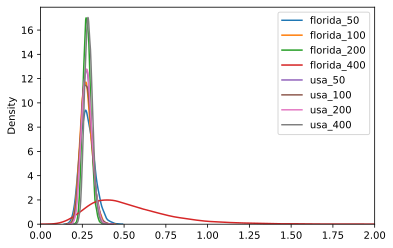

<IPython.core.display.Javascript object>

In [10]:
for i, b in enumerate(regions):
    for n in n_tipss:
        sns.kdeplot(
            res_tips[f"{b}_{n}"].global_posteriors["origin"].flatten(), label=f"{b}_{n}"
        )
plt.xlim(0, 2)
plt.legend()

## BEAST

In [7]:
beast = {}
ks = ["florida", "michigan", "usa"]
# ks = ["florida", "michigan"]
ns = [100, 500]
sampling = ["random", "stratified"]

for k in ks:
    for n in ns:
        for s in sampling:
            beast[f"{k}_{n}_{s}"] = AlignIO.read(
                f"covid/beast/covid/{k}_{n}_{s}.fa", format="fasta"
            )

dates = defaultdict(list)
names = defaultdict(list)
for k, v in beast.items():
    for s in v:
        date = datetime.strptime(s.id.split("_")[-1], "%Y-%m-%d")
        dates[k].append(date)
        names[k].append(s.id)

<IPython.core.display.Javascript object>

In [8]:
beast_data = {k: SeqData(v, names=names[k], dates=dates[k]) for k, v in beast.items()}

<IPython.core.display.Javascript object>

In [9]:
def parse_log(fname):
    with open(fname) as fp:
        for line in fp:
            line = line.strip()
            if line.startswith("Sample"):
                keys = line.split("\t")
                sample_dict = {k: [] for k in keys}
                idx_dict = {j: k for j, k in enumerate(keys)}
            elif not line.startswith("#") and len(line) != 0:
                for j, h in enumerate(line.split("\t")):
                    sample_dict[idx_dict[j]].append(float(h))

        for k, v in sample_dict.items():
            sample_dict[k] = np.array(v[1:])
    return sample_dict

<IPython.core.display.Javascript object>

In [10]:
short_dicts = {}
for k in ks:
    for n in ns:
        for s in sampling:
            short_dicts[f"{k}_{n}_{s}"] = parse_log(
                f"covid/beast/covid/short/logs/{k}_{n}_{s}.log"
            )

<IPython.core.display.Javascript object>

In [11]:
long_dicts = {}
for k in ks:
    for n in ns:
        for s in sampling:
            long_dicts[f"{k}_{n}_{s}"] = parse_log(
                f"covid/beast/covid/long/logs/{k}_{n}_{s}.log"
            )

<IPython.core.display.Javascript object>

In [12]:
def plot_beast(sample_dict, ax, param, end, label, ci, title):
    x0 = np.linspace(2020, end, 100)

    ys = []
    m = 0
    for k, v in sample_dict.items():
        if param in k:
            ys.append(v)
            m += 1
    ys = np.array(ys).T
    y0 = []

    try:
        top = sample_dict["origin_BDSKY_Serial"]
    except:
        top = sample_dict["origin_BDSKY_Contemp"]
    for x, y in zip(top, ys):
        intervals = np.linspace(0, x, m + 1)
        t = (end - intervals)[::-1]
        y0.append(interp1d(t[1:], y, kind="nearest", fill_value="extrapolate")(x0))
    q25, q50, q75 = np.quantile(np.array(y0), q=[0.025, 0.5, 0.975], axis=0)

    color = next(ax._get_lines.prop_cycler)["color"]
    ax.plot(x0, q50, label=label, color=color)
    if ci == "fill":
        ax.fill_between(x0, q25, q75, alpha=0.1, label="_nolegend_", color=color)
    if ci == "lines":
        ax.plot(x0, q25, "--", label="_nolegend_", alpha=0.25, color=color)
        ax.plot(x0, q75, "--", label="_nolegend_", alpha=0.25, color=color)
    # plt.xlim(reversed(plt.xlim()))
    ax.set_xlabel("Year")
    ax.set_title(title)

<IPython.core.display.Javascript object>

In [21]:
def beast_comparison_plot_helper(k, param, ax, s, length="short"):
    ns = [100, 500]
    bdsky_label = {"random": "Serial", "stratified": "Contemp"}
    plot_label = {"random": "random", "stratified": "contemporary"}
    color = next(ax._get_lines.prop_cycler)["color"]
    if k != "usa" and param in "reproductiveNumber_BDSKY":
        ax.plot(external[k]["time"], external[k]["rt"], label="Surveillance Data")
        ax.fill_between(
            external[k]["time"],
            external[k]["rt_lower"],
            external[k]["rt_upper"],
            alpha=0.1,
            label="_nolegend_",
        )
    else:
        color = next(ax._get_lines.prop_cycler)["color"]

    for n in ns:
        if length == "short":
            logs = short_dicts[f"{k}_{n}_{s}"]
        else:
            logs = long_dicts[f"{k}_{n}_{s}"]

        plot_beast(
            logs,
            ax,
            f"{param}_{bdsky_label[s]}",
            beast_data[f"{k}_{n}_{s}"].end,
            label=f"BEAST - {n} tips, {plot_label[s]}",
            ci="fill",
            title="",
        )


def beast_comparison_plot(k, param, length):
    if param == "reproductiveNumber_BDSKY":
        fig, axs = plt.subplots(2)
        beast_comparison_plot_helper(k, param, axs[0], "random", length)
        beast_comparison_plot_helper(k, param, axs[1], "stratified", length)
        height = 7
    else:
        fig, ax = plt.subplots()
        beast_comparison_plot_helper(k, param, ax, "random", length)
        axs = [ax]
        height = 3.5

    for ax in axs:
        if param == "reproductiveNumber_BDSKY":
            ax.set_ylim(0, 2)
            ax.set_xlim(2020, 2021.9)
            ax.legend(loc="lower left")

    fig.set_size_inches(10, height)
    if k == "usa":
        part1 = k.upper()
    else:
        part1 = k.title()

    vbsky_label = {"reproductiveNumber_BDSKY": "R", "samplingProportion_BDSKY": "s"}

    _title = f"{part1} - {vbsky_label[param]} - {length.title()}"
    fig.suptitle(_title)

    fig.savefig(
        f"covid/figures/beast/{k}_{vbsky_label[param]}_{length}.pdf", format="pdf"
    )

<IPython.core.display.Javascript object>

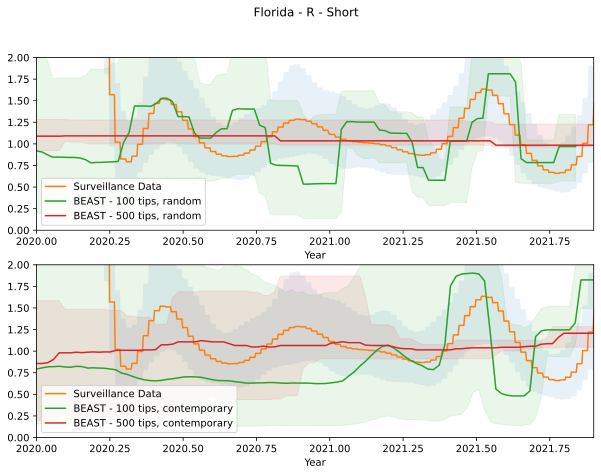

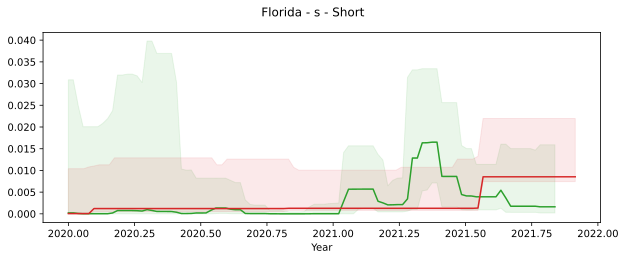

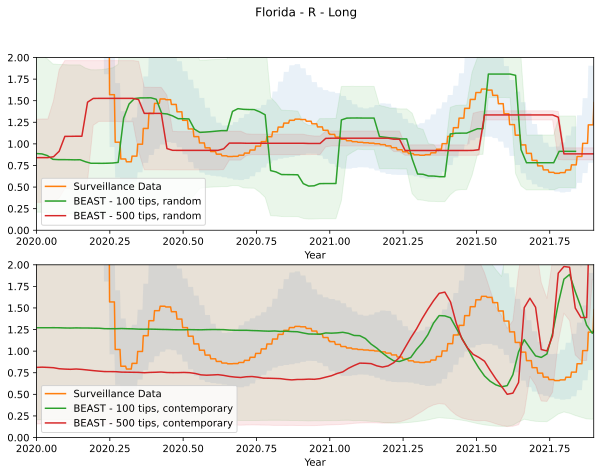

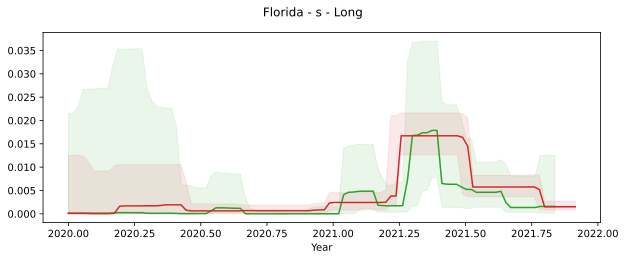

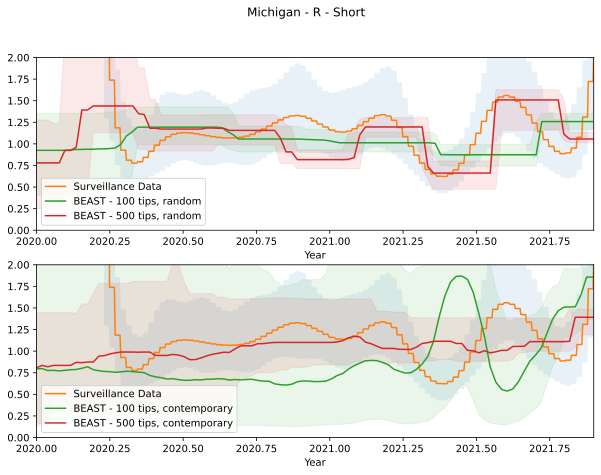

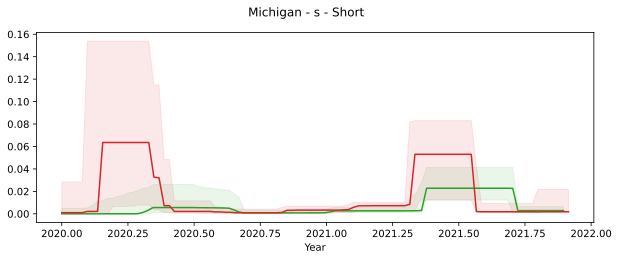

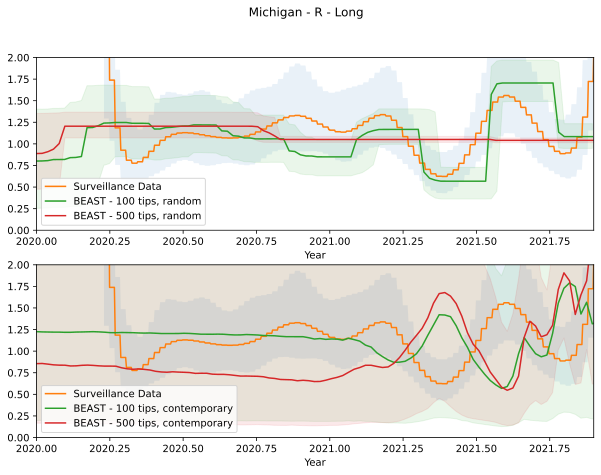

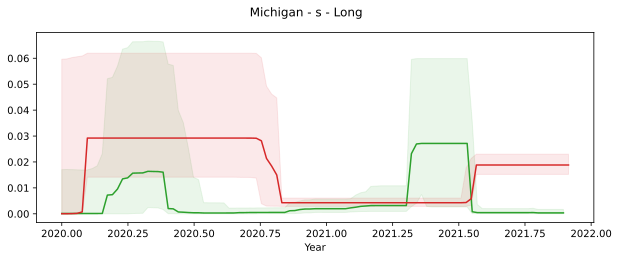

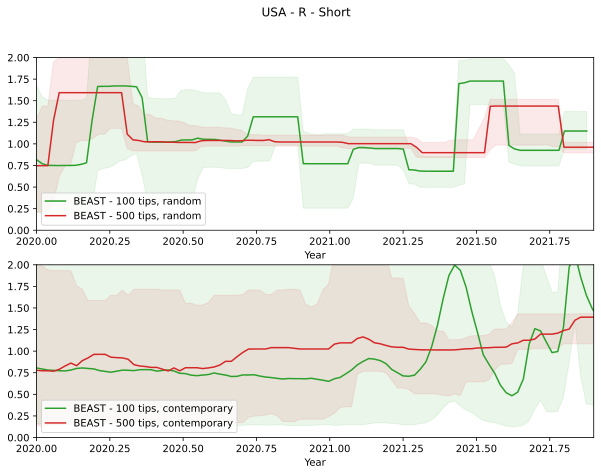

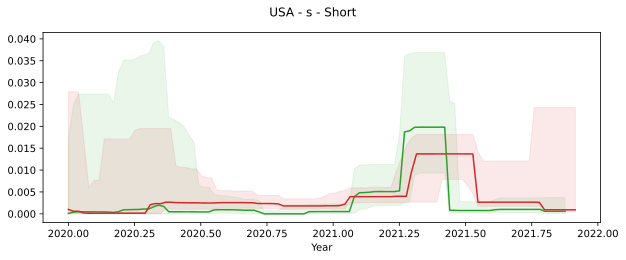

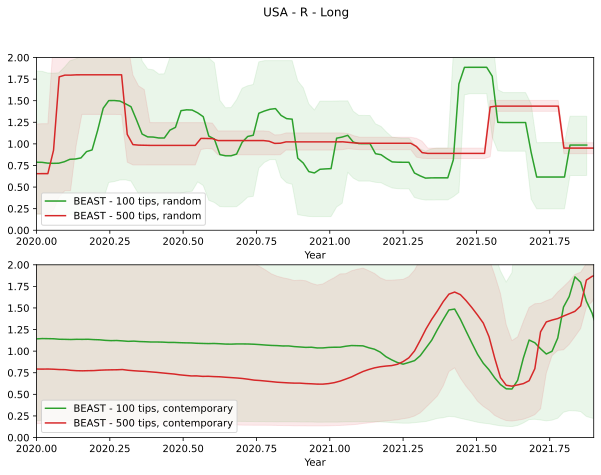

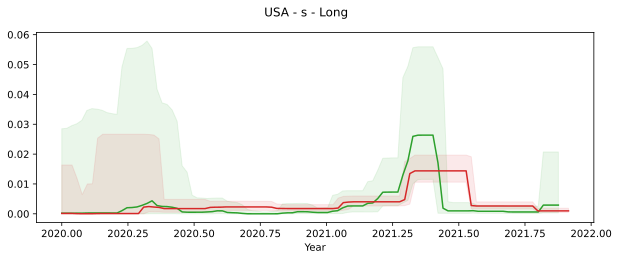

<IPython.core.display.Javascript object>

In [22]:
for k in ["florida", "michigan", "usa"]:
    for length in ["short", "long"]:
        for param in ["reproductiveNumber_BDSKY", "samplingProportion_BDSKY"]:
            beast_comparison_plot(k, param, length)

## Case count data

In [12]:
usa_df = pd.read_csv("covid/us_cases.csv")
states_cases = pd.read_csv("covid/states_cases.csv")
florida_df = states_cases.loc[states_cases["state"] == "Florida"]
michigan_df = states_cases.loc[states_cases["state"] == "Michigan"]

<IPython.core.display.Javascript object>

In [145]:
florida_df.index[0]

242

<IPython.core.display.Javascript object>

In [13]:
def format_df(df):
    df["daily"] = df["cases"].diff()
    df.loc[df.index[0], "daily"] = df.loc[df.index[0], "cases"]
    df["date"] = pd.to_datetime(df["date"])
    df["decimal_date"] = df["date"].dt.year + (df["date"].dt.dayofyear - 1) / 365
    df["seven_day"] = df["daily"].rolling(7).mean()

<IPython.core.display.Javascript object>

In [14]:
format_df(usa_df)
format_df(florida_df)
format_df(michigan_df)

/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_1693/211479654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["daily"] = df["cases"].diff()
/Users/calebki/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_1693/211479654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

<IPython.core.display.Javascript object>

In [158]:
florida_df.loc[florida_df["seven_day"] < 0]

,date,state,fips,cases,deaths,daily,decimal_date,seven_day
25213,2021-06-04,Florida,12,2289332,36985,-40527.0,2021.421918,-4496.857143
25268,2021-06-05,Florida,12,2289332,36985,0.0,2021.424658,-4496.857143
25323,2021-06-06,Florida,12,2289332,36985,0.0,2021.427397,-4496.857143
25378,2021-06-07,Florida,12,2294049,37025,4717.0,2021.430137,-3823.000000
25433,2021-06-08,Florida,12,2295233,37025,1184.0,2021.432877,-4502.000000
25488,2021-06-09,Florida,12,2296823,37161,1590.0,2021.435616,-4451.142857
25543,2021-06-10,Florida,12,2298549,37206,1726.0,2021.438356,-4472.857143


<IPython.core.display.Javascript object>

In [164]:
florida_df.loc[
    (florida_df["decimal_date"] < 2021.427397) & (florida_df["decimal_date"] > 2021.415)
]

,date,state,fips,cases,deaths,daily,decimal_date,seven_day
25103,2021-06-02,Florida,12,2327981,36923,1234.0,2021.416438,1692.428571
25158,2021-06-03,Florida,12,2329859,36972,1878.0,2021.419178,1626.714286
25213,2021-06-04,Florida,12,2289332,36985,-40527.0,2021.421918,-4496.857143
25268,2021-06-05,Florida,12,2289332,36985,0.0,2021.424658,-4496.857143


<IPython.core.display.Javascript object>

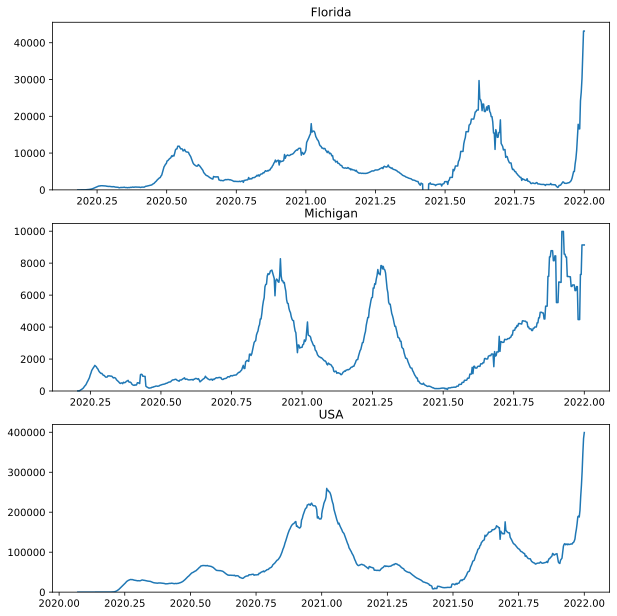

<IPython.core.display.Javascript object>

In [15]:
fig, axs = plt.subplots(3)
titles = ["Florida", "Michigan", "USA"]
for i, df in enumerate([florida_df, michigan_df, usa_df]):
    axs[i].plot(df["decimal_date"], df["seven_day"])
    axs[i].set_title(titles[i])
    axs[i].set_ylim(bottom=0)
fig.set_size_inches(10, 10.5)
fig.savefig(f"covid/figures/all/case_count.pdf", format="pdf")